## Ocean thermal forcing and basal melt in the Control Ensemble

The control ensemble shows an inverse relationship between basal melt sensitivity (gamma0) and sea level contribution, contrary to my expectations. This notebook investigates the ISMIP6 quadratic non-local basal melt parameterisation used in the control ensemble and tries to explain this relationship.

In [1]:
import os
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict

The quadratic non-local basal melt parameterisation ([Favier et al., 2016](https://gmd.copernicus.org/articles/12/2255/2019/)) defines a relationship between thermal forcing (a combination of temperature and salinity) and the basal melt rate of ice shelves: 

$$ m(x, y) = \gamma_0 \times \left( \frac{\rho_{sw} c_{pw}}{\rho_i L_f} \right)^2
     \times (TF(x, y, z_{draft}) + \delta T_{sector})
     \times (\langle TF \rangle _{draft \in sector} + \delta T_{sector})$$

This is the parameterisation used in the control ensemble, but NB. the parameterisation was updated by [Jourdain et al. (2020)](https://tc.copernicus.org/articles/14/3111/2020/) so that the last bracket always returns an absolute value:

$$ m(x, y) = \gamma_0 \times \left( \frac{\rho_{sw} c_{pw}}{\rho_i L_f} \right)^2
     \times (TF(x, y, z_{draft}) + \delta T_{sector})
     \times | \langle TF \rangle _{draft \in sector} + \delta T_{sector} |$$

The reasoning by Jourdain et al. was that the previous parameterisation allows for 'spurious refreezing' in cases of high basal melt sensitivity. I wondered whether this was the cause of my confusing results in the control ensemble.

In [3]:
# set up the parameterisation in python, ignoring non-gamma constants because they only scale the results anyway
def favier_m(gamma: float, TF: float, TF_sec: float, dT: float) -> float:
    return gamma * (TF + dT) * (TF_sec + dT)

def jourdain_m(gamma: float, TF: float, TF_sec: float, dT: float) -> float:
    return gamma * (TF + dT) * abs(TF_sec + dT)

### $\delta T$ corrections for each basin and $\gamma_0$ value

In [4]:
# to plot the melt rate, we need values for dT, which vary according to the value of gamma0 and the glacier basin
path = '/Users/jonniebarnsley/data/phd/Control/dT/'
data = os.listdir(path)
data.sort()
data

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonniebarnsley/data/phd/Control/dT/'

In [33]:
# define a function to help plot dT files
def plot_dt(filename: str, ax: mpl.axes) -> None:
    file = xr.open_dataset(path+filename, engine='netcdf4')
    dT = file.deltaT_basin

    x = file.x
    y = file.y

    xs = x - x.mean()
    ys = y - y.mean()

    kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
    ax.pcolormesh(xs, ys, dT, transform=ccrs.Stereographic(**kw), vmin=-1, vmax=1)
    ax.coastlines(lw=0.3)
    ax.set_title(filename, fontsize=6)

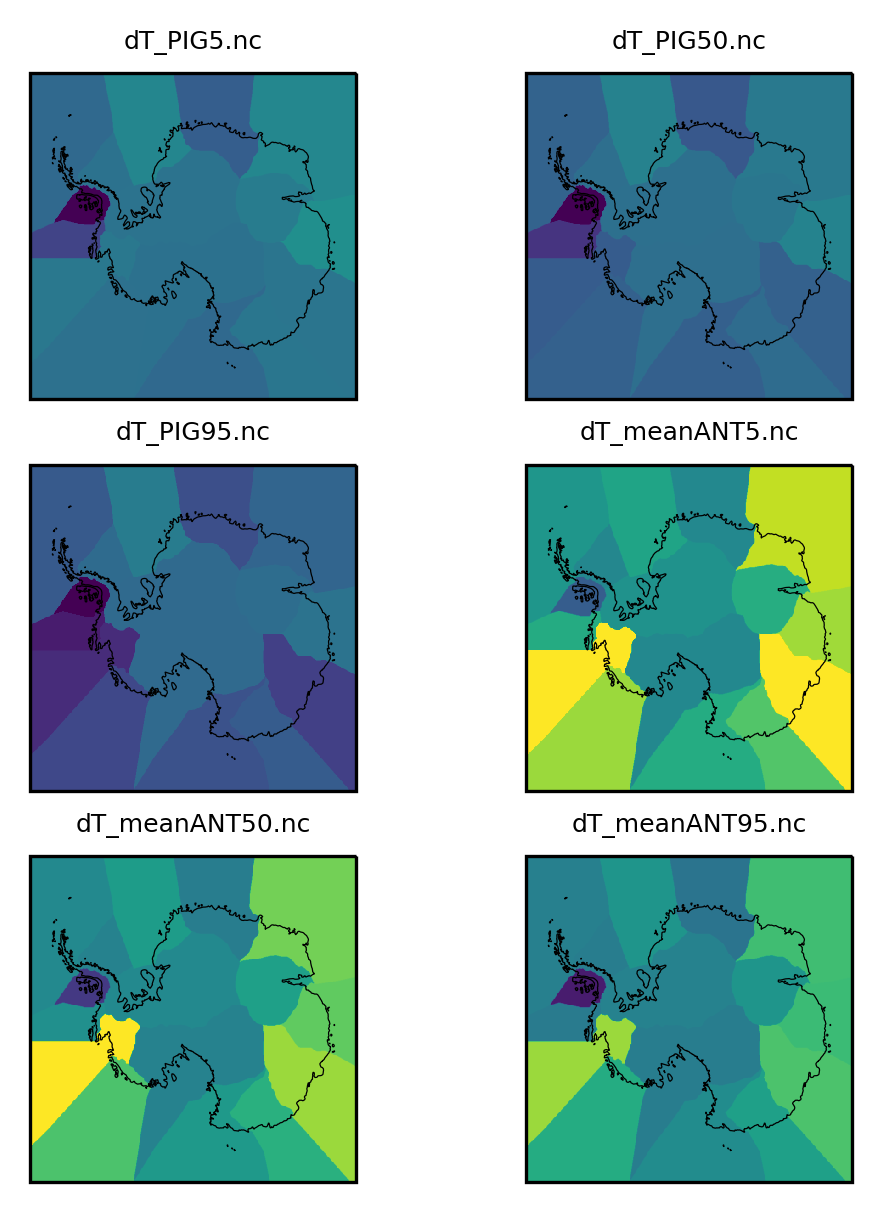

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=2, subplot_kw={'projection': ccrs.SouthPolarStereo()}, dpi=300)

for ax, filename in zip(axes.flatten(), data):
    plot_dt(filename, ax)

fig.subplots_adjust(wspace=-.5)

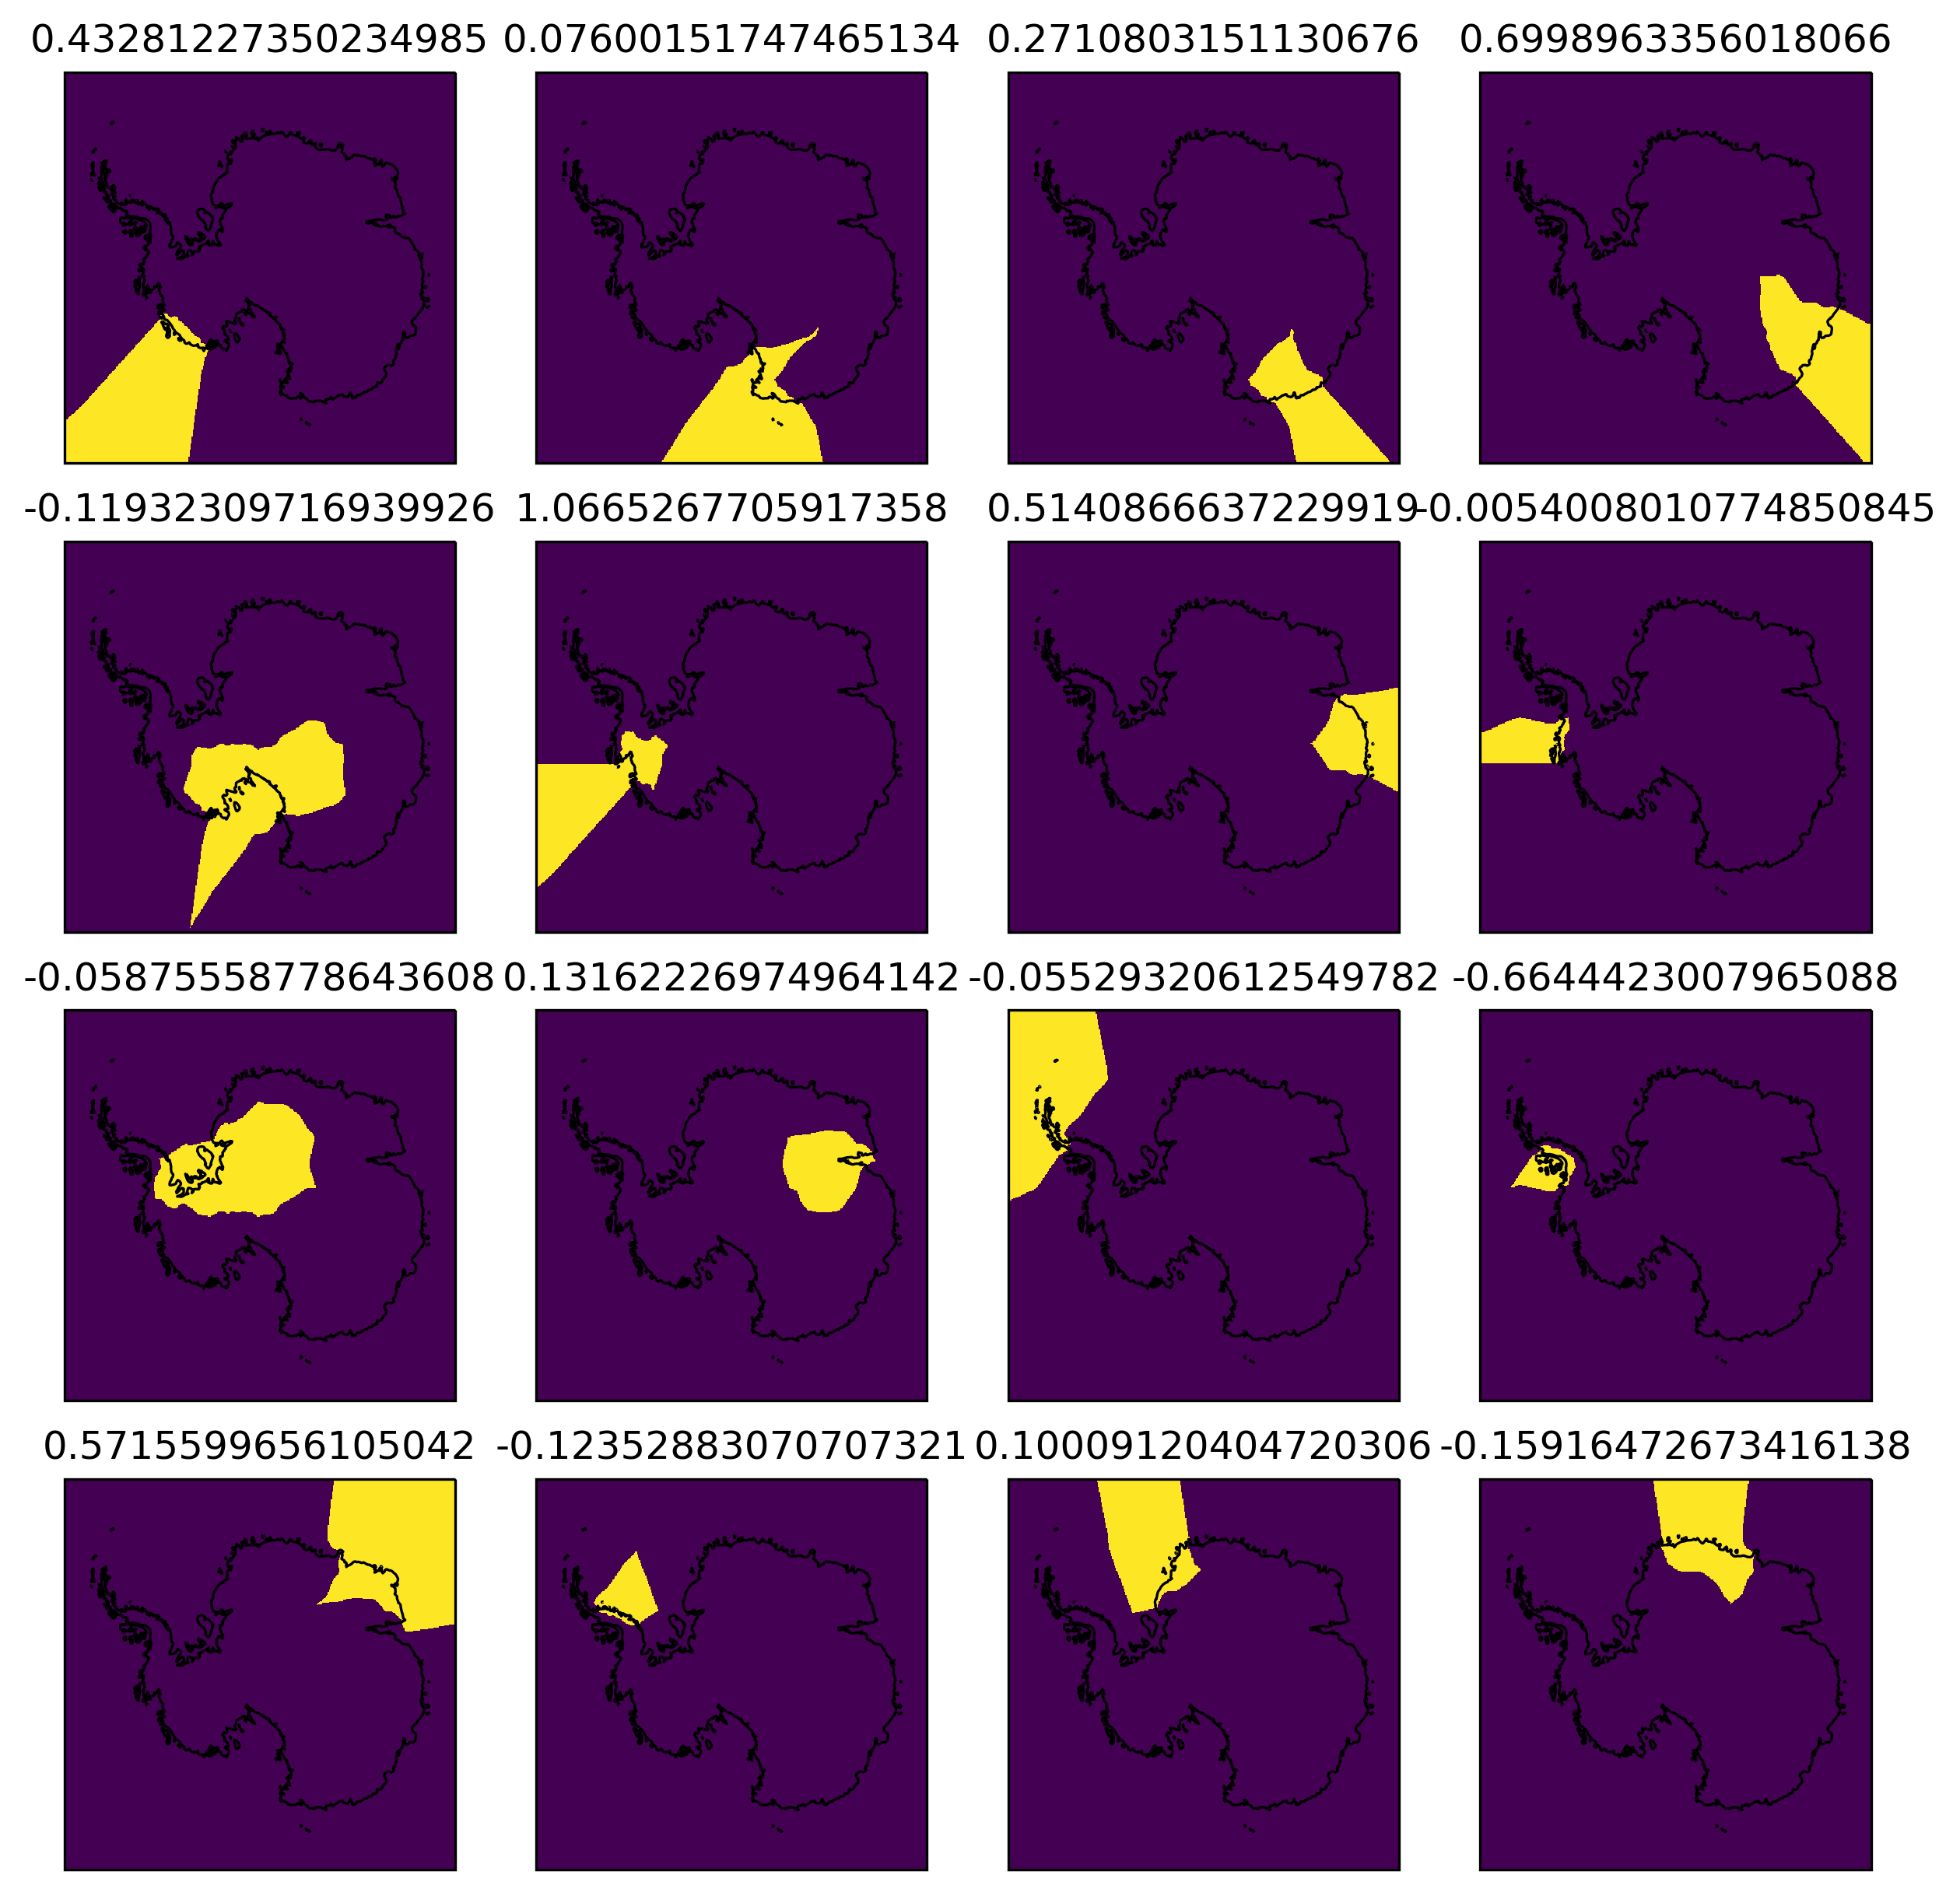

In [44]:
# We need masks for each basin, so let's use one of the dT files to generate these
filename = 'dT_meanANT50.nc'
file = xr.open_dataset(path+filename, engine='netcdf4')
meanANT50_dT = file.deltaT_basin

# first, make a list of dT values found in the array. There seem to be some weird things happening
# around the border of basins, so we're going to select only dT values that appear more than 100 times.

vals = meanANT50_dT.values.flatten()
seen = defaultdict(int) # value defaults to zero if key doesn't exist

# generate dictionary of pixel values and how often they appear
for pixel in vals:
    seen[pixel] +=1

x = meanANT50_dT.x
y = meanANT50_dT.y

xs = x - x.mean()
ys = y - y.mean()

# filter out only values seen more than 100 times
vals = []
for pixel in seen:
    if seen[pixel] > 100:
        vals.append(pixel)

# plot each basin along with its value
fig, axes = plt.subplots(nrows=4, ncols=4, subplot_kw={'projection': ccrs.SouthPolarStereo()}, figsize=(10, 10), dpi=300)
kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)

for val, ax in zip(vals, axes.flatten()):
    mask = meanANT50_dT == val
    ax.pcolormesh(xs, ys, mask, transform=ccrs.Stereographic(**kw))
    ax.coastlines(lw=0.8)
    ax.set_title(val)

In [46]:
# using the above plot, make a dictionary of masks for each basin
masks = {
    'Amundsen'      : meanANT50_dT == 1.0665267705917358,
    'Ross'          : meanANT50_dT == -0.11932309716939926,
    'Wilkes'        : meanANT50_dT == 0.2710803151130676,
    'Aurora'        : meanANT50_dT == 0.6998963356018066,
    'Filchner-Ronne': meanANT50_dT == -0.0587555877864360,
    'Recovery'      : meanANT50_dT == 0.10009120404720306
}

### Ocean Thermal Forcing